# Data 

This is the third tutorial notebook in the iterative ptychography series.  
In this tutorial notebook we will cover:
- Parameter optimization

### Downloads
This tutorial uses the following datasets:
- [ptycho_ducky_simulation_03.h5](https://drive.google.com/file/d/1rCWIokqDGINpex_zYz4ryiiEkfuh1xTI/view?usp=drive_link)
- [ptycho_ducky_vacuum-probe_03.h5](https://drive.google.com/file/d/1aiZbsXU1dUf4RIHZDLUbWsGZlZZAaClM/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Steven Zeltmann (steven.zeltmann@lbl.gov)
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated 2024 May 3

## Parameter Optimization
We have already seen the importance of having accurate calibrations for phase retrieval, and investigated two powerful methods for obtaining good estimates:
- DPC: CoM curl minimization &rarr; rotation estimate
- Parallax: Cross-correlation shifts fitting &rarr; rotation, defocus, astigmatism etc estimates

There are however additional parameters, such as the reciprocal-space pixel-size, sample thickness (multi-slice) etc, which these methods don't inform us about and are of crucial importance to ptychographic reconstructions.

Here, we present a general framework to perform grid-search as-well as Bayesian inference optimization using Gaussian processes.

### Ducky Simulated Data
We'll investigate the optimizer using the simulated ducky dataset we've been looking at, where we know the true calibrations

In [16]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)

0.14.18


In [2]:
# Load the data
path = 'C:\\_Data\\wendy_data\\'
al1_file_data = path + 'al_alo_2_03_master.h5'
probe_path = path + 'al_alo_2_12_master.h5'
al2_file_data = path + 'pt_02_master.h5' #fine name incorrect. Actually taken on aluminum sample

In [3]:
# py4DSTEM.save(data = dataset_masked, filepath= path + 'processed_al_alo_2_03_master.h5')
# py4DSTEM.save(data = probe_masked, filepath= path + 'processed_al_alo_2_12_master.h5')


Because the file format is not native to py4DSTEM, we need to use import_file function. 

In [3]:
# Import the datasets
al1_dataset = py4DSTEM.import_file(al1_file_data,)
al2_dataset = py4DSTEM.import_file(al2_file_data,)
probe = py4DSTEM.import_file(probe_path)

Dataset is uint32 but will be converted to uint16
Dataset is uint32 but will be converted to uint16
Dataset is uint32 but will be converted to uint16


In [10]:
for dataset_1 in [al1_dataset, al2_dataset, probe]:
    d = dataset_1.data
    print(np.max(d.data))
    print(np.min(d.data))
    print(d.data.shape)
    dataset_1.get_dp_mean() #this calculates the mean of the diffraction pattern will help the next step

65535
0
(256, 256, 192, 192)
65535
0
(256, 256, 192, 192)
65535
0
(16, 16, 192, 192)


There are hot pixels in the dataest, so we need to mask them. 

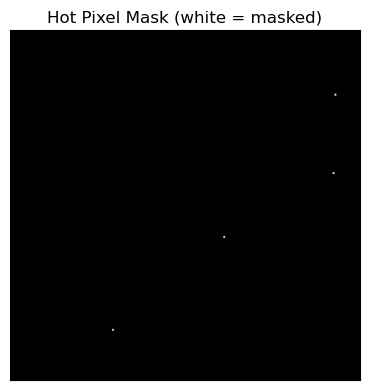

Maximum value 36


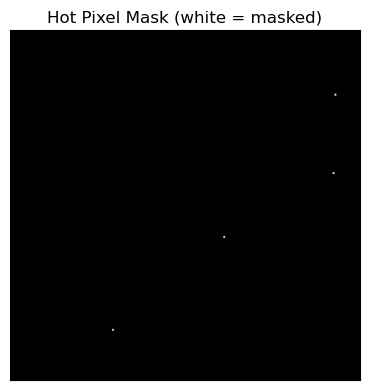

Maximum value 48


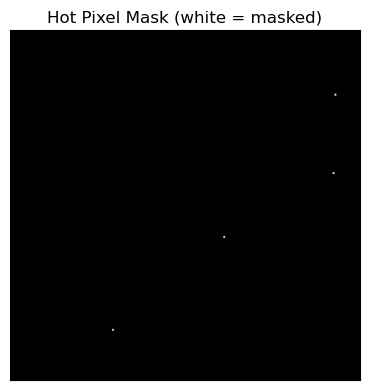

Maximum value 24


In [11]:
dataset_masked = []
for data in [al1_dataset, al2_dataset, probe,]:
    mask_hotpixel = data.tree('dp_mean').data>100
    masked = data.median_filter_masked_pixels(mask = mask_hotpixel, kernel_width = 5)
    masked.get_dp_max();
    masked.get_dp_mean();
    # Plot the hot pixel mask
    py4DSTEM.show(
        mask_hotpixel,
        cmap='gray',
        figsize=(4,4),
        ticks=False,
        title='Hot Pixel Mask (white = masked)',
    )
    plt.show()
    dataset_masked.append(masked)
    print('Maximum value', np.max(masked.tree('dp_max').data))
al1_dataset_masked, al2_dataset_masked, probe_masked = dataset_masked

In [13]:
for dataset_1 in [al1_dataset_masked, al2_dataset_masked, probe_masked]:
    d = dataset_1.data
    print(np.max(d.data))
    print(np.min(d.data))
    print(d.data.shape)

36
0
(256, 256, 192, 192)
48
0
(256, 256, 192, 192)
24
0
(16, 16, 192, 192)


In [14]:
print(probe.calibration)
print(al1_dataset.calibration)
print(al2_dataset.calibration)

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    0.34555085515441486
             Q_pixel_units:   pixels
             R_pixel_units:   A
             QR_flip:         False
)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             QR_flip:         False
)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    0.35634931937799036
             Q_pixel_units:   pixels
             R_pixel_units:   A
             QR_flip:         False
)


Probe Center = (101.72719204575263, 93.5080013466016) pixels 
Probe Radius = 66.007 pixels


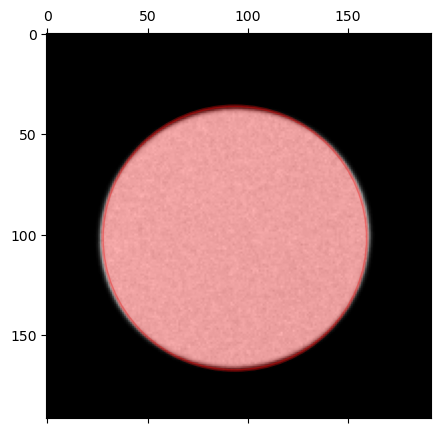

In [20]:
# Estimate the position of the zero beam

# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = probe_masked.get_probe_size(
    thresh_lower=0.000000001,
    thresh_upper=0.6,
    plot=True,
    
)
center = (probe_qx0, probe_qy0)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
print(f"Probe Center = {center} pixels ")
print(f"Probe Radius = {np.round(probe_semiangle, 3)} pixels")


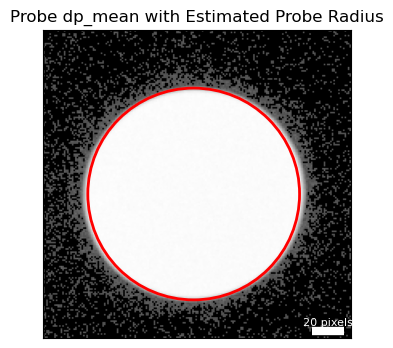

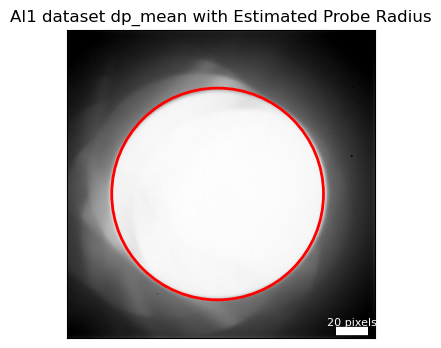

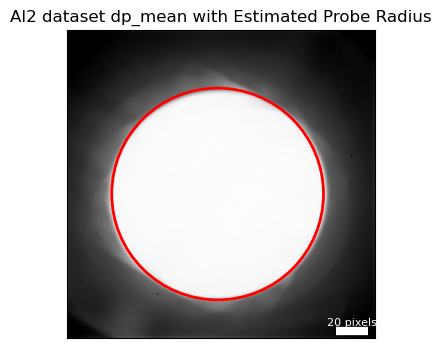

In [ ]:
py4DSTEM.show(
    probe_masked.tree('dp_mean'),
    figsize=(4,4),
    circle = {
        'center': center,
        'R': probe_semiangle,
    },
    ticks = False,
    returnfig = True,
    vmax = 10,
    power = 0.15,
    title='Probe dp_mean with Estimated Probe Radius',
)
plt.show()

py4DSTEM.show(
    al1_dataset_masked.tree('dp_mean'),
    figsize=(4,4),
    circle = {
        'center': center,
        'R': probe_semiangle,
    },
    ticks = False,
    returnfig = True,
    vmax = 10,
    power = 0.15,
    title='Al1 dataset dp_mean with Estimated Probe Radius',
)
plt.show()

py4DSTEM.show(
    al2_dataset_masked.tree('dp_mean'),
    figsize=(4,4),
    circle = {
        'center': center,
        'R': probe_semiangle,
    },
    ticks = False,
    returnfig = True,
    vmax = 10,
    power = 0.15,
    title='Al2 dataset dp_mean with Estimated Probe Radius',
)
plt.show()

We know the measurements was taken at 30mrad semi angle, then we can update the calibration.

In [22]:
r_pixel_size = probe_masked.calibration['R_pixel_size']

print(f"Real space pixel size: {r_pixel_size} A")

Real space pixel size: 0.34555085515441486 A


In [ ]:
# q_pixel_size = 0.45449762893741413
# q_pixel_unit = 'mrad'

# r_pixel_size = 0.34555085515441486
# r_pixel_unit = 'A'

In [24]:
probe_step_size_Ang = 30
probe_pixel_number = probe_semiangle

q_pixel_size = probe_step_size_Ang / probe_pixel_number
print(f"Diffraction space pixel size: {q_pixel_size} mrad")


Diffraction space pixel size: 0.45449762893741413 mrad


In [26]:
r_pixel_unit = 'A'
q_pixel_unit = 'mrad'
# Diffraction space
for data in dataset_masked:# pt_data]:
    data.calibration.set_Q_pixel_size(q_pixel_size)
    data.calibration.set_Q_pixel_units(q_pixel_unit)
    data.calibration.set_R_pixel_size(r_pixel_size)
    data.calibration.set_R_pixel_units(r_pixel_unit)
    
    data.get_dp_max()
    data.get_dp_mean()

In [27]:
print(probe.calibration)
print(al1_dataset.calibration)
print(al2_dataset.calibration)

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      0.45449762893741413
             R_pixel_size:      0.34555085515441486
             Q_pixel_units:     mrad
             R_pixel_units:     A
             QR_flip:           False
             probe_semiangle:   66.00694500901588
             qx0_mean:          101.72719204575263
             qy0_mean:          93.5080013466016
)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.45449762893741413
             R_pixel_size:    0.34555085515441486
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.45449762893741413
             R_pixel_size:    0.34555085515441486
             Q_pixel_units:   mrad
             R_pixel_units: 

### Save processed data

In [28]:
py4DSTEM.save(data = al1_dataset_masked, filepath= path + 'processed_al1.h5')
py4DSTEM.save(data = al2_dataset_masked, filepath= path + 'processed_al2.h5')
py4DSTEM.save(data = probe_masked, filepath= path + 'processed_probe.h5')


###  Select window to save data

In [ ]:
d = al1_dataset_masked
name = 'al1_dataset_masked'

select_loc = 110
select_window = 40
data_partial = d.data[select_loc:select_loc+select_window,
                      select_loc:select_loc+select_window,
                      :,:]

In [50]:
datacube_partial = py4DSTEM.DataCube(data = data_partial, calibration=d.calibration)

A 'calibration' key already exists in root.metadata - overwriting...


In [51]:
py4DSTEM.save(
    data = datacube_partial,
    filepath = path + f'{name}_partial_loc{select_loc}_w{select_window}.h5',)
del datacube_partial

Notice how the optimized result is not in-fact the true calibration of 500 A defocus!  
This highlights the risks of blindly using the self-consistency error as an optimization function. To remedy this, `optimize` function accepts an `error_metric` argument, with a variety of predefined and custom metrics.